<a href="https://colab.research.google.com/github/FernandoSimon22/vision_artificial/blob/main/YOLOv12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [ ]:
import os

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="lX9sE2RPQOCv2R7cn0io")
project = rf.workspace("jota22").project("am_boundingbox")
version = project.version(14)
dataset = version.download("yolov12")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to AM_BoundingBox-14 in yolov12:: 100%|██████████| 392/392 [00:00<00:00, 4847.36it/s]


### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [ ]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

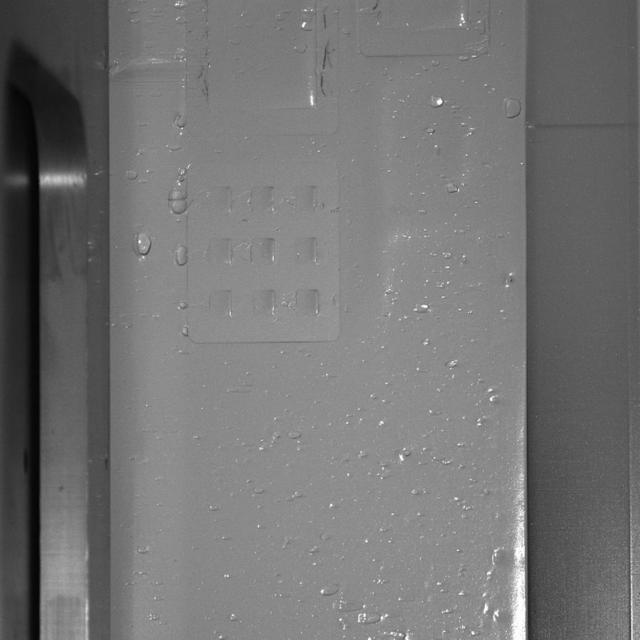

In [ ]:
from IPython.display import Image, display
display(Image("/content/AM_BoundingBox-14/train/images/069b2cf6-6_94_png.rf.66c058f5ac6336df563f07627d14ed35.jpg"))


## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


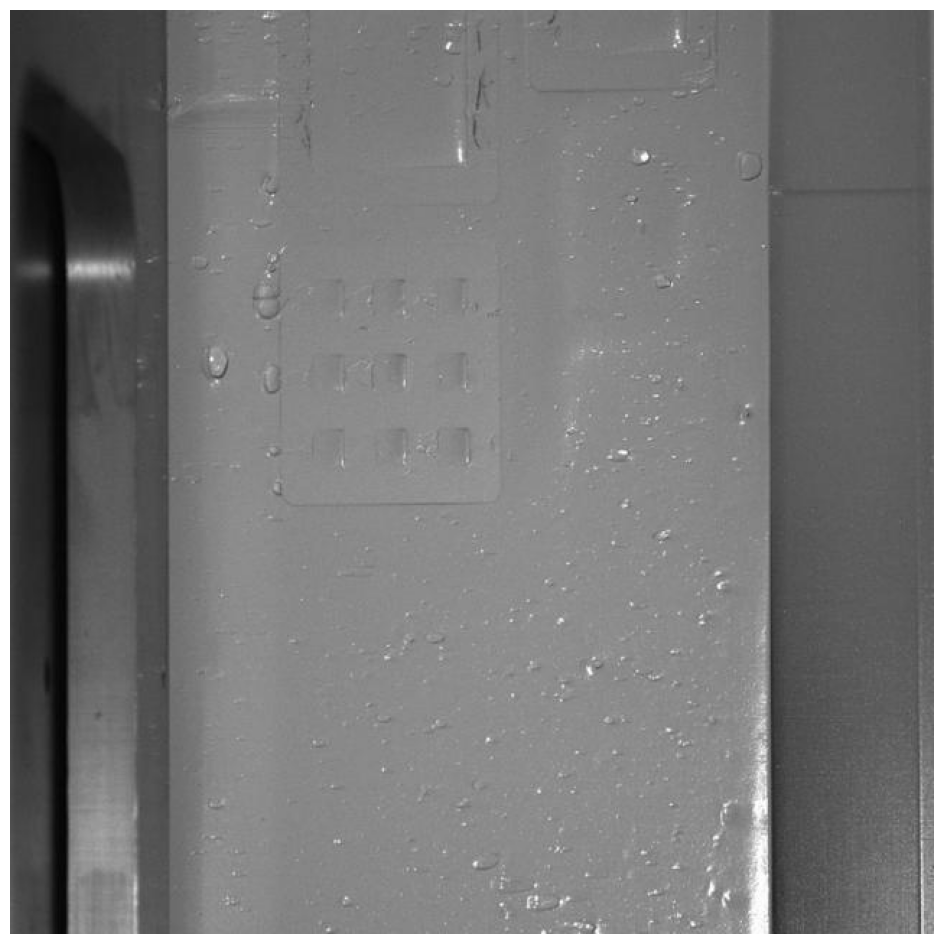

In [ ]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"/content/AM_BoundingBox-14/train/images/069b2cf6-6_94_png.rf.66c058f5ac6336df563f07627d14ed35.jpg"
image = cv2.imread(image_path)

if image is None:
    print(f"Error: Could not load image from {image_path}. Please check the file path and ensure the image exists.")
else:
    model = YOLO('yolov12m.pt')

    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="lX9sE2RPQOCv2R7cn0io")
project = rf.workspace("jota22").project("am_boundingbox")
version = project.version(14)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...


In [ ]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [ ]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: /content/AM_BoundingBox-14/test\ntrain: /content/AM_BoundingBox-14/train\nval: /content/AM_BoundingBox-14/valid" >> {dataset.location}/data.yaml

In [ ]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['def']

roboflow:
test: /content/AM_BoundingBox-14/test
train: /content/AM_BoundingBox-14/train
val: /content/AM_BoundingBox-14/valid


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov12m.pt')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=300, imgsz=960)

New https://pypi.org/project/ultralytics/8.3.124 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12m.pt, data=/content/AM_BoundingBox-14/data.yaml, epochs=300, time=None, patience=100, batch=16, imgsz=960, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 254435 has 14.73 GiB memory in use. Of the allocated memory 14.33 GiB is allocated by PyTorch, and 256.99 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Evaluate fine-tuned YOLOv12 model

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train2/

args.yaml					    results.png
confusion_matrix_normalized.png			    train_batch0.jpg
confusion_matrix.png				    train_batch1710.jpg
events.out.tfevents.1746210419.4a4099b2928a.1057.1  train_batch1711.jpg
F1_curve.png					    train_batch1712.jpg
labels_correlogram.jpg				    train_batch1.jpg
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg
PR_curve.png					    val_batch0_pred.jpg
R_curve.png					    weights
results.csv


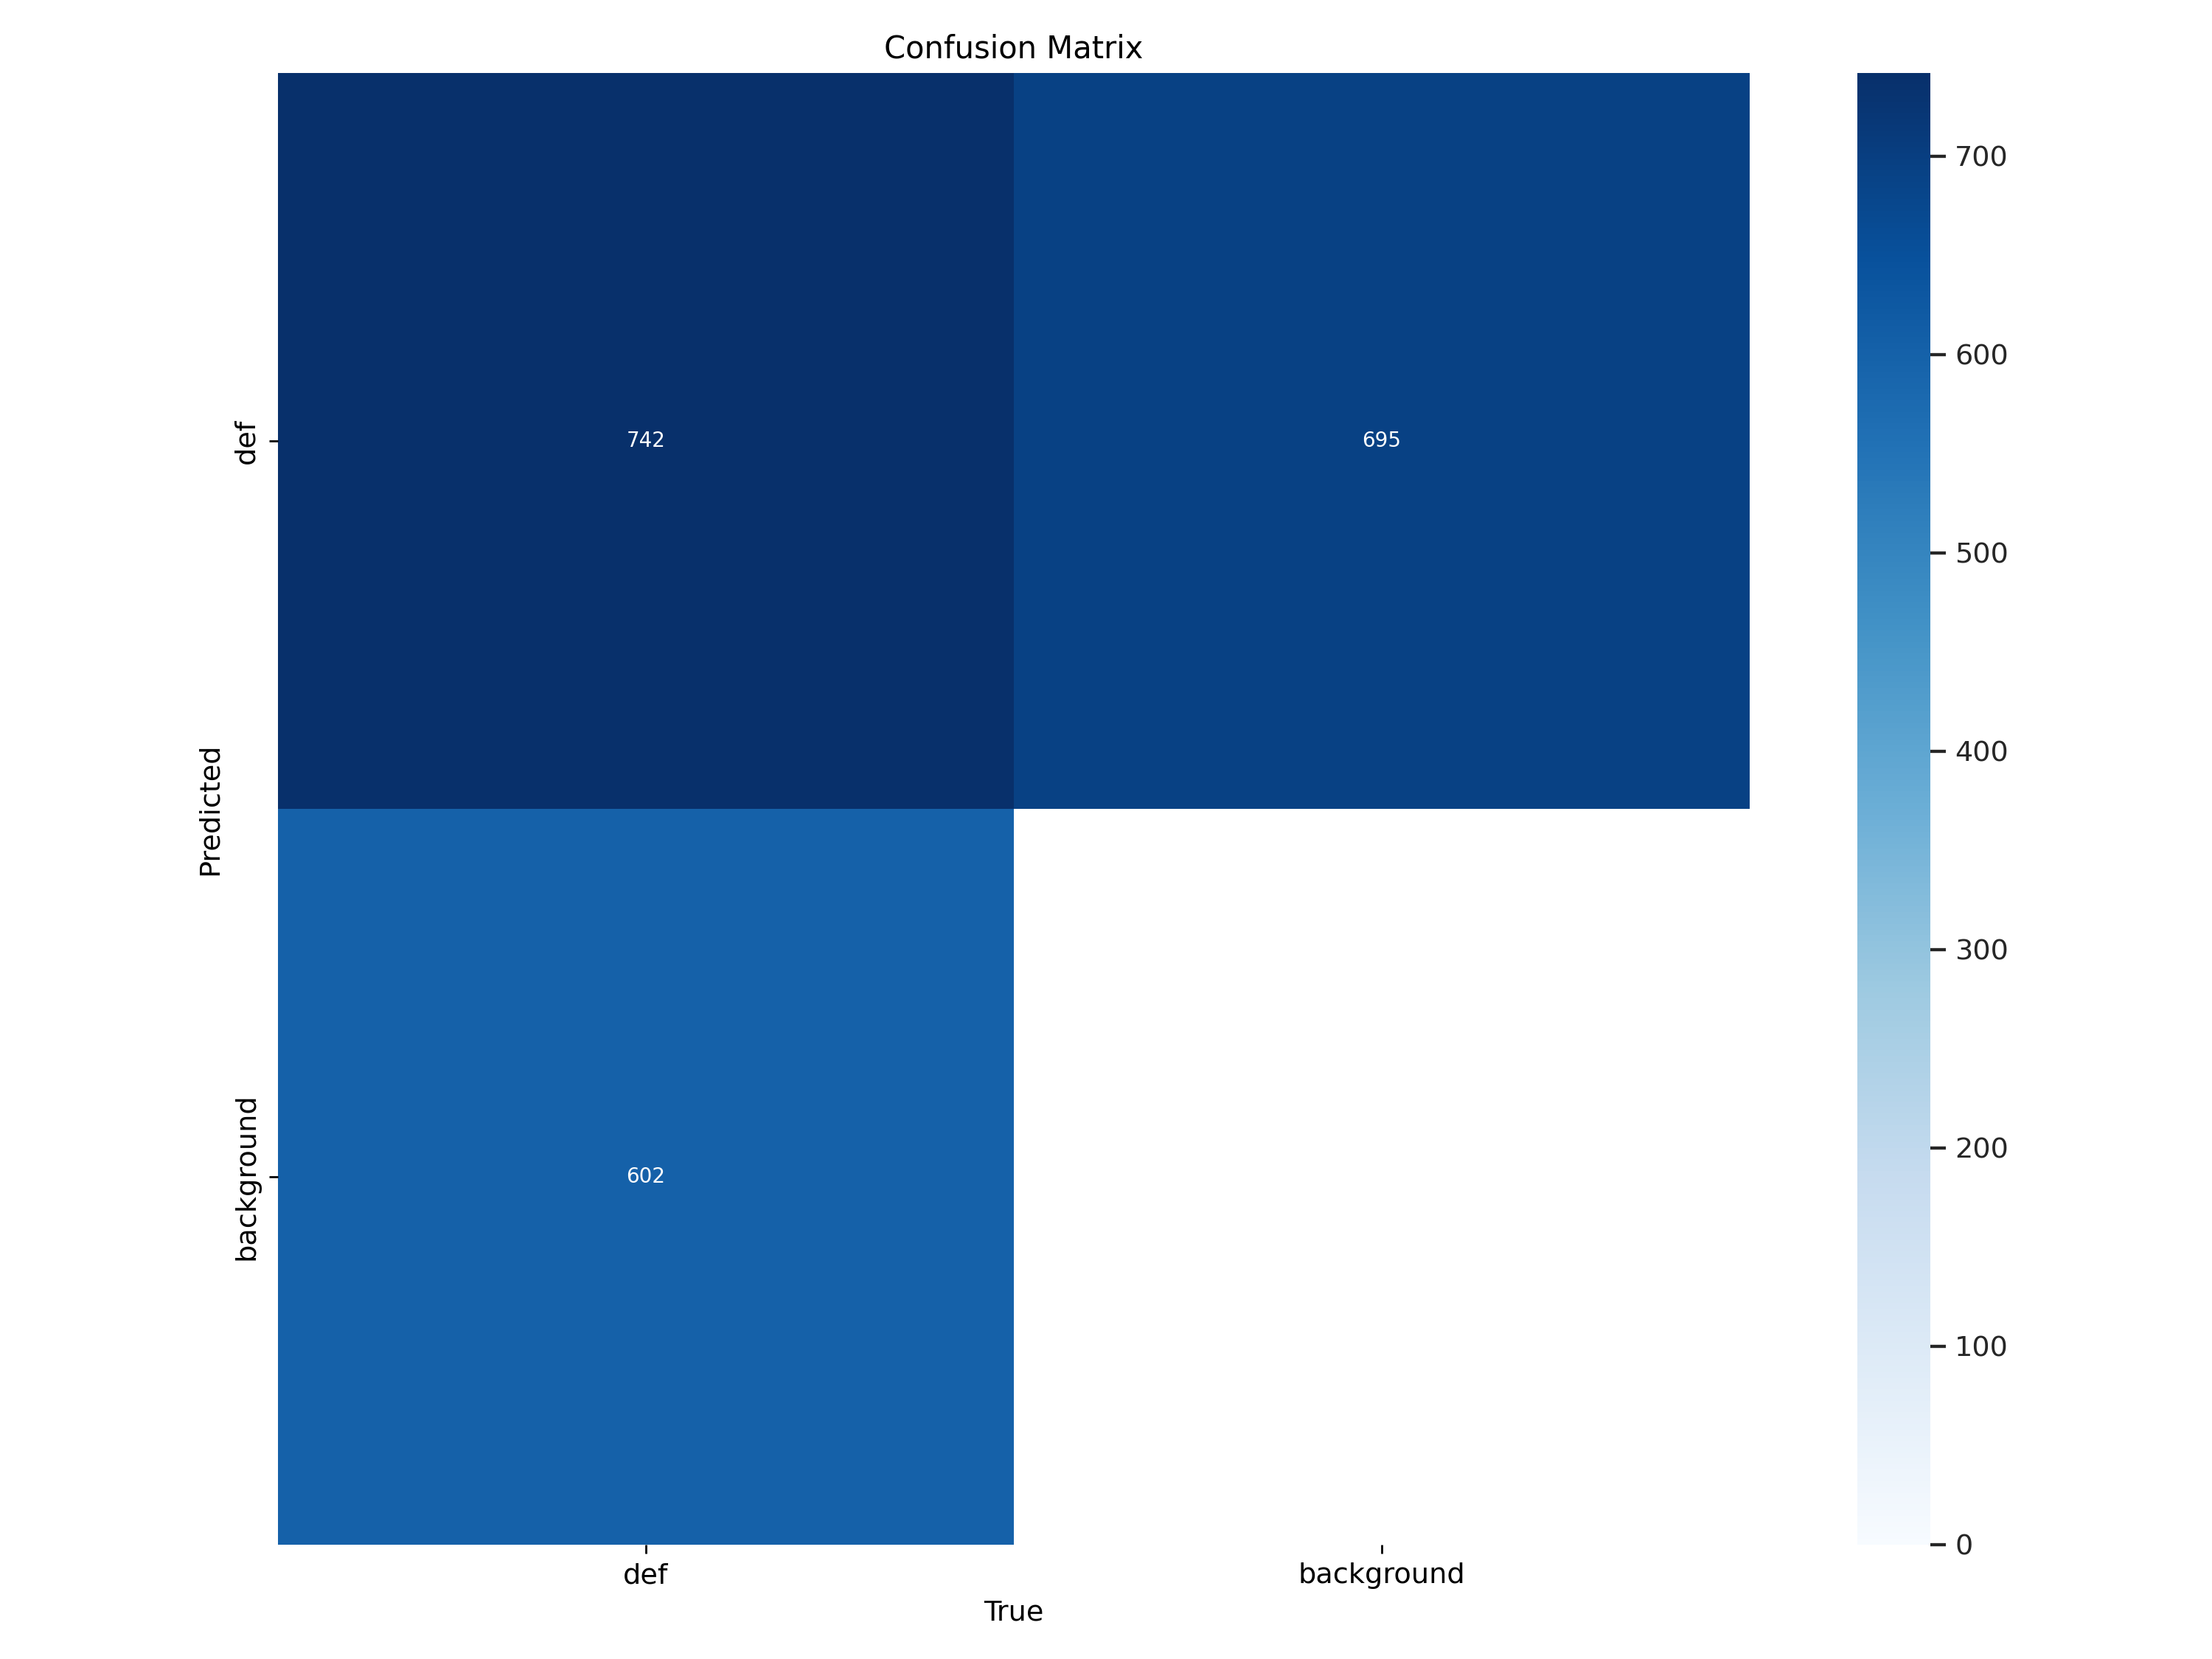

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=1000)

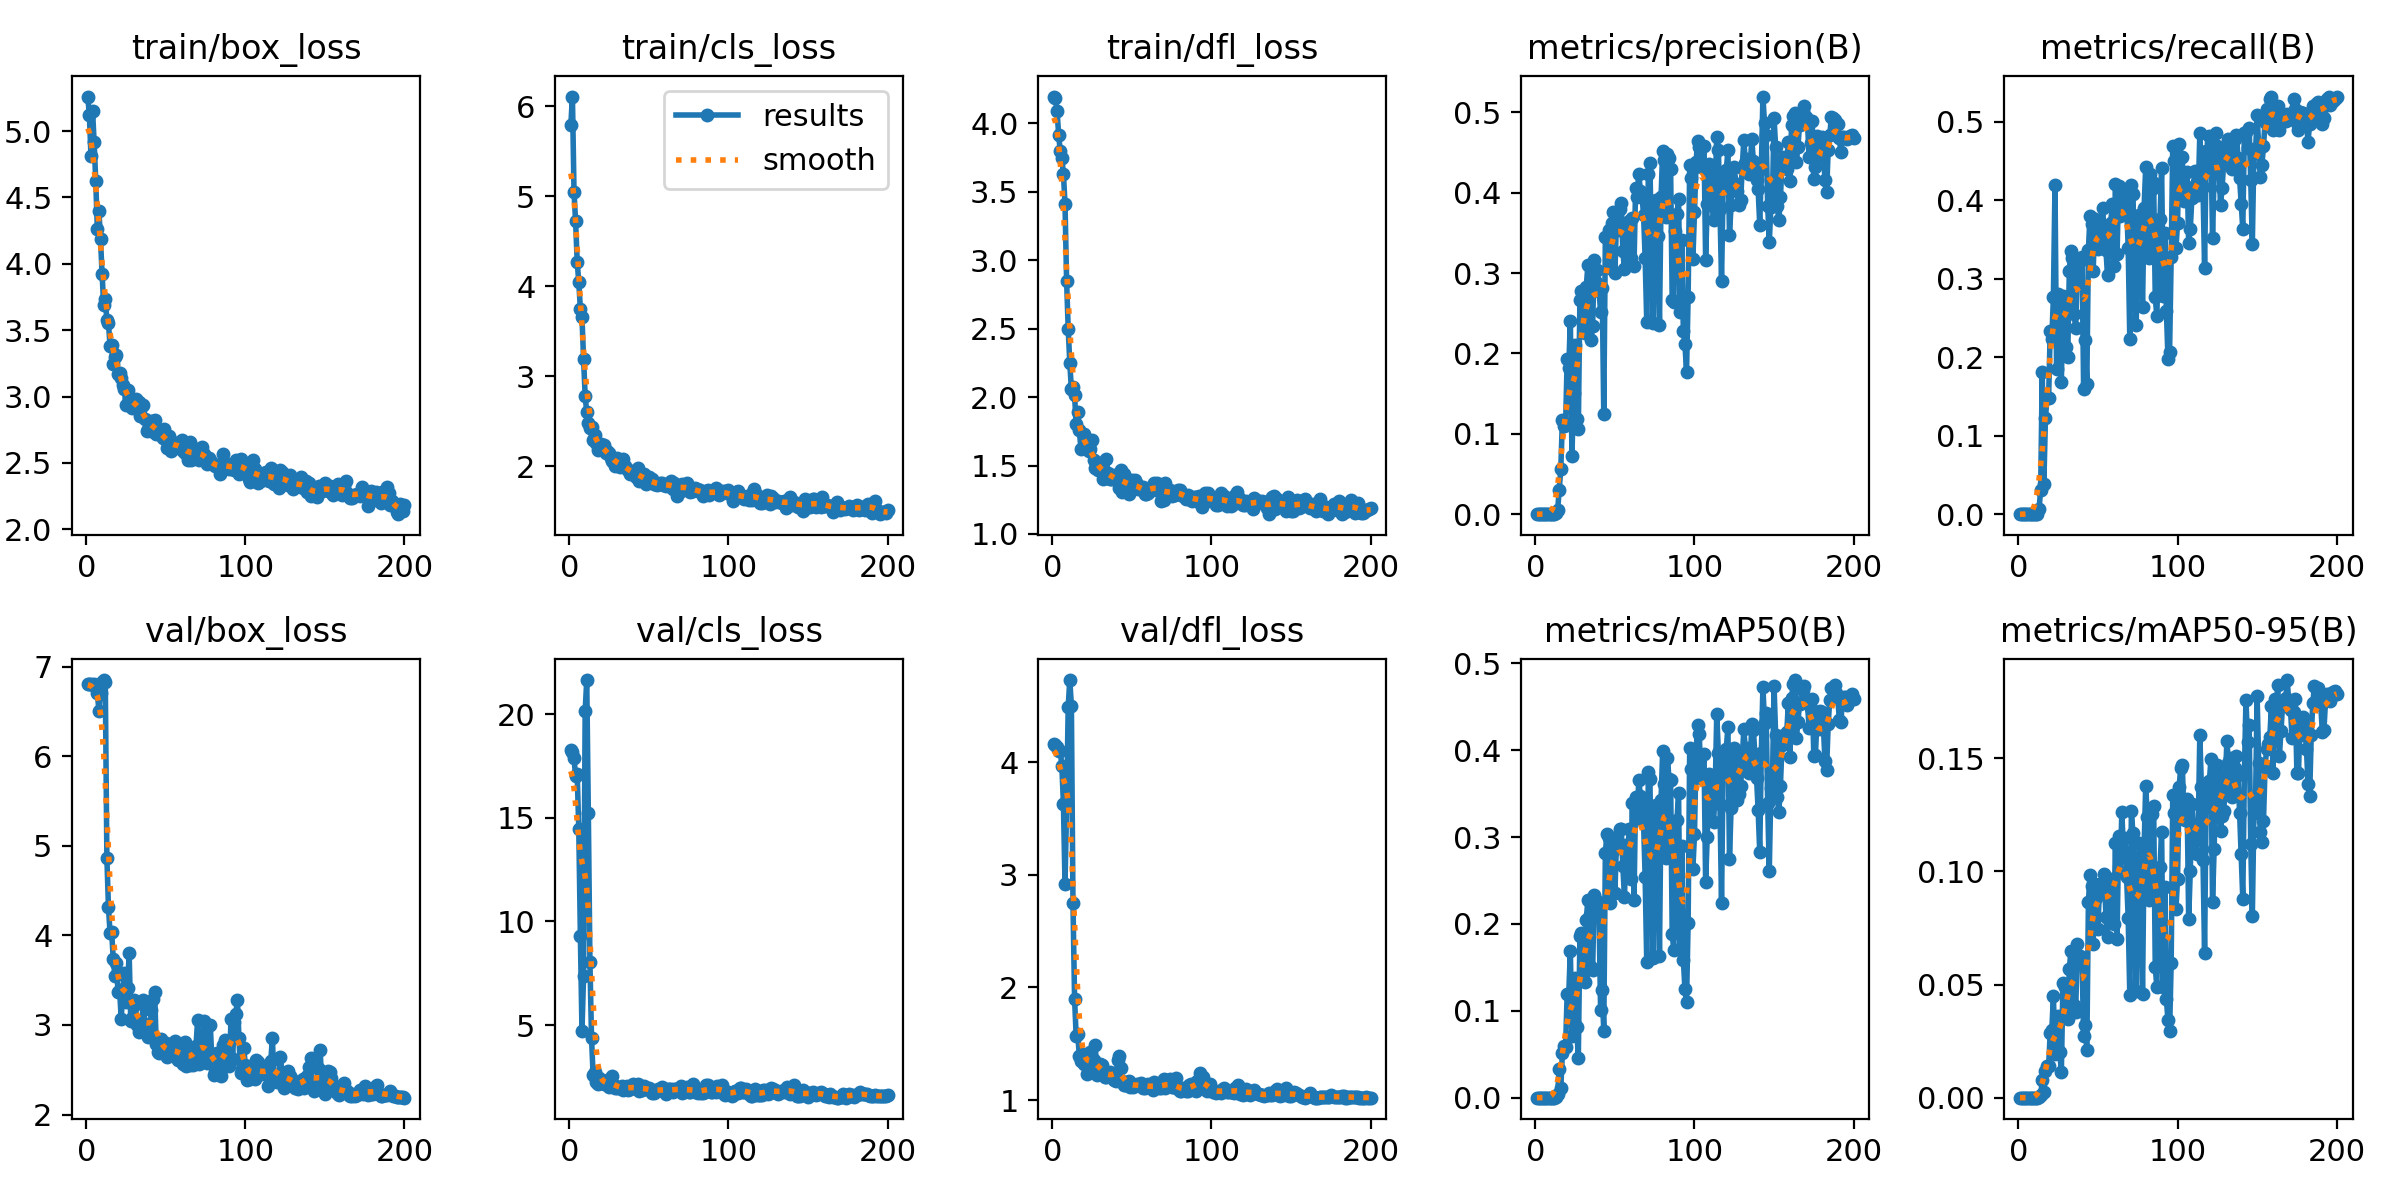

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train2/results.png', width=1000)

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['def']

In [ ]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train2/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [ ]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.13695371558205244
mAP 50 0.3355476205654159
mAP 75 0.08038256433293778


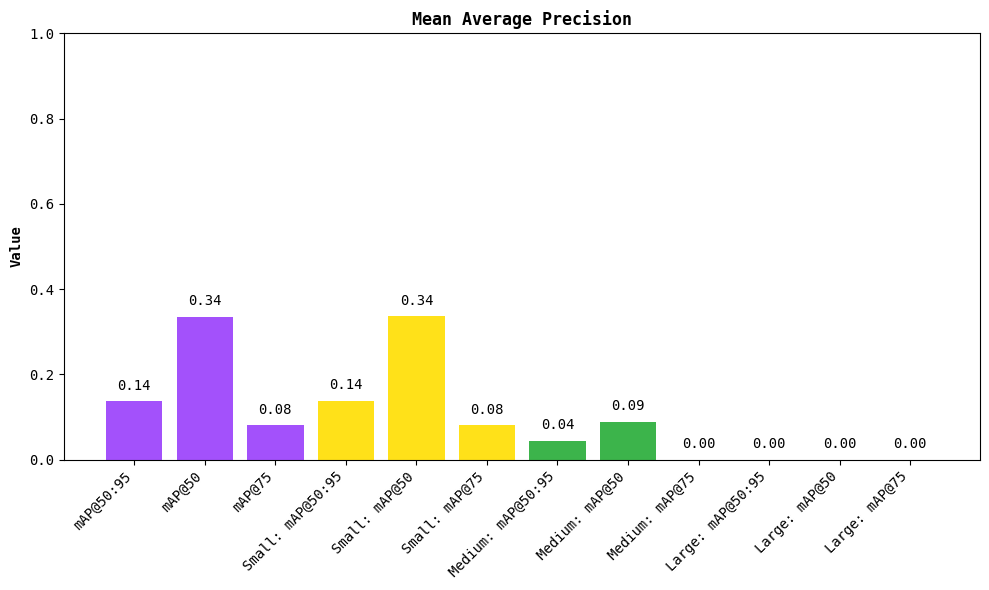

In [ ]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [ ]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train2/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

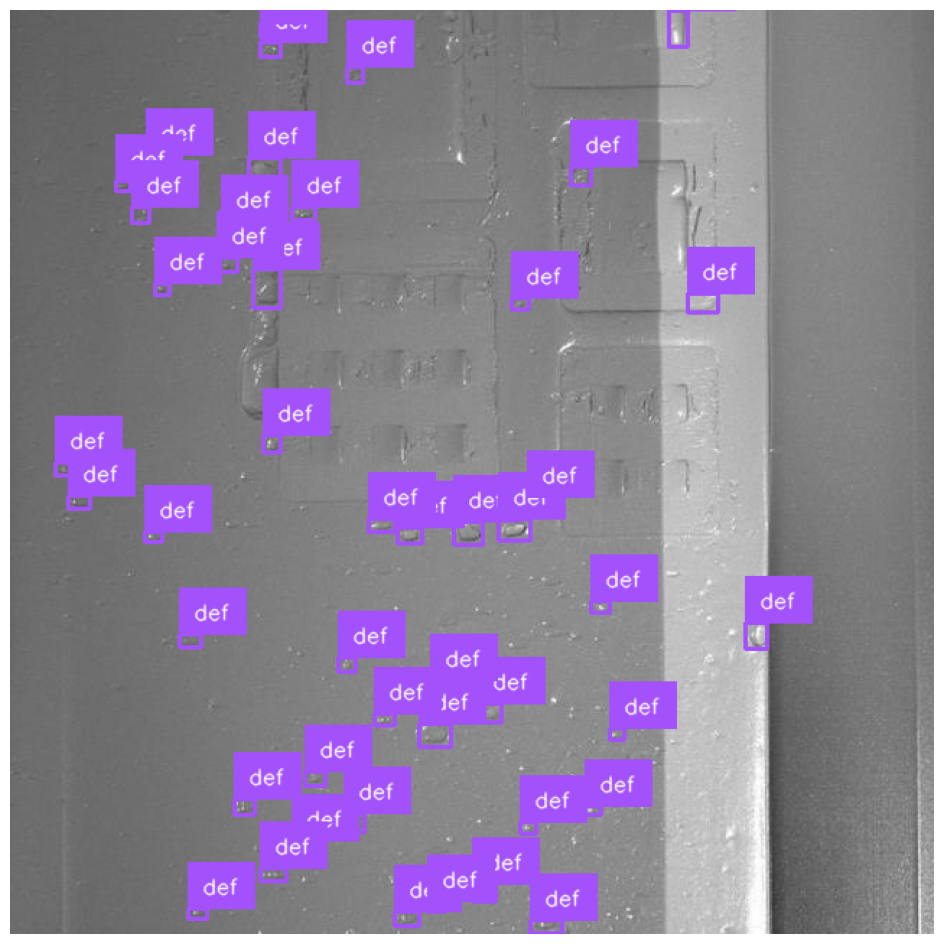

In [ ]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)